# Выпускной проект - Телекоммуникации


Задача - компания оператор связи планирует внедрить прогноз оттока клиентов для своевременного принятия мер по предотвращению.
В распоряжении персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
- Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Ключевые приемы для решения задачи:
- загрузка данных (try/except)
- анализ (head, info, describe) + визуализация распределений, выводы
- составить план работы + вопросы
- объединение таблиц не теряя данных, обработка пропусков, не плодить лишних категорий
- анализ по группам оттока
- создание признака 'длительность' в днях
- признаки с датами приводят к утечке
- контроль мультиколлинеарности при лин. моделях, вывод матрицы коллинеарности при исп. лин моделей, phik
- дисбаланс классов не редактируем, возможно настройка через ГП модели при оценке других метрик, upsampling приводит к утечке, roc-auc устойчива к дисбалансу
- разделение на выборки: делим на 2 выборки, test_size=0.25
- кодирование: не использовать get_dummies и ручное кодирование, OHE возможно с pipelines, Ordinal Encoding не исп. для линейных моделей (только OHE + масштабирование) - подходит для деревьев и boost моделей, для LGBM и cat_boost лучше не кодировать признаки
- масштабирование для деревьев и boost моделей не нужно, масштабировать имеет смысл только численные признаки
- моделирование: тестим минимум 3 модели, подбор ГП через grid_search и аналоги (без циклов), не делаем predict, fit или fit/transform применятеся только к train выборкам, к test только transform
- только кросс-валидация
- ROC-AUC >= 0.85, возможно введение доп. метрик: время обучения, recall, precision (в оптимизатор можно передать список метрик с refit=главная метрику), только predict_proba на тесте
- оцениваем важность признаков + матрица ошибок с комментриями, библиотека ?shap?
- особое внимание к п.4 и 5 в Части 3.
- целевой признак формируется на основе EndDate

Описание признаков.

Таблица contract:
- customerID — ID абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Таблица personal:
- customerID — ID пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Таблица internet
- customerID — ID пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Таблица phone:
- customerID — ID пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#План проекта" data-toc-modified-id="План проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>План проекта</a></span>
<li><span><a href="#Объединение таблиц" data-toc-modified-id="Объединение таблиц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Объединение таблиц</a></span></li><li><span><a href="#Машинное обучение" data-toc-modified-id="Машинное обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Машинное обучение</a></span></li><li><span><a href="#Отчет" data-toc-modified-id="Отчет-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Отчет</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

In [1]:
RANDOM_STATE = 310723

## План проекта
1. Изучить таблицы по отдельности:
- head, info, describe
- проверить пропуски
- проверить дубликаты
- проверить качество и типы данных 
- построить распределения ключевых признаков для выявления явных закономерностей
- обработка / создание доп. признаков
2. Объединить таблицы в одну
- заполнить NaN
- проверить коллинеарность факторов
- определить целевой признак
- определение признаков для обучения и удаление лишних признаков
- разделить данные на две выборки
- закодировать данные, если требуется
3. МО
- определение используемых моделей
- обучение моделей с подбором гиперпараметров
- выбор дополнительных метрик на кросс-валидации для оценки в случае близких показателей: время обучения, recall, precision, ...
- составление рейтинга моделей и определение лучшей
- проверка качества модели на тестовой выборке
- оценка важности признаков, применение матрицы ошибок
4. Подготовка комплексного отчета

In [2]:
! pip install phik
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
import phik
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, TimeSeriesSplit
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

     |████████████████████████████████| 679 kB 1.0 MB/s eta 0:00:01


In [3]:
contract = pd.read_csv('/datasets/contract_new.csv')
personal = pd.read_csv('/datasets/personal_new.csv')
internet = pd.read_csv('/datasets/internet_new.csv')
phone = pd.read_csv('/datasets/phone_new.csv')

1.1. Изучим таблицы по отдельности

In [4]:
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Прпусков нет.

Изучение значений в столбце TotalCharges:

In [6]:
np.unique(contract['TotalCharges'])

array([' ', '100.17', '100.19', ..., '998.89', '999.6', '999.9'],
      dtype=object)

Присутсвуют значения ' ', исправим:

In [7]:
contract['TotalCharges'].value_counts()[' ']

11

In [8]:
contract.loc[contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [9]:
max(contract['BeginDate'])

'2020-02-01'

Все значения относятся к крайней дате заключения договора - имеет смысл приравнять сначения TotalCharges к MonthlyCharges:

In [10]:
contract.loc[(contract.TotalCharges == ' '), 'TotalCharges'] = contract['MonthlyCharges']

Проверка:

In [11]:
contract.iloc[[0, 3, 488, 1082, 6670]]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,52.55
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,25.75
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,73.35


Заменяем тип на численный:

In [12]:
contract['TotalCharges'] = contract['TotalCharges'].apply(pd.to_numeric)

In [13]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


In [14]:
contract.describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2115.377573
std,30.090047,2112.678861
min,18.250000,19.050000
25%,35.500000,436.750000
50%,70.350000,1343.350000
75%,89.850000,3236.690000
max,118.750000,9221.380000


In [15]:
contract.duplicated().sum()

0

Дубликатов нет.

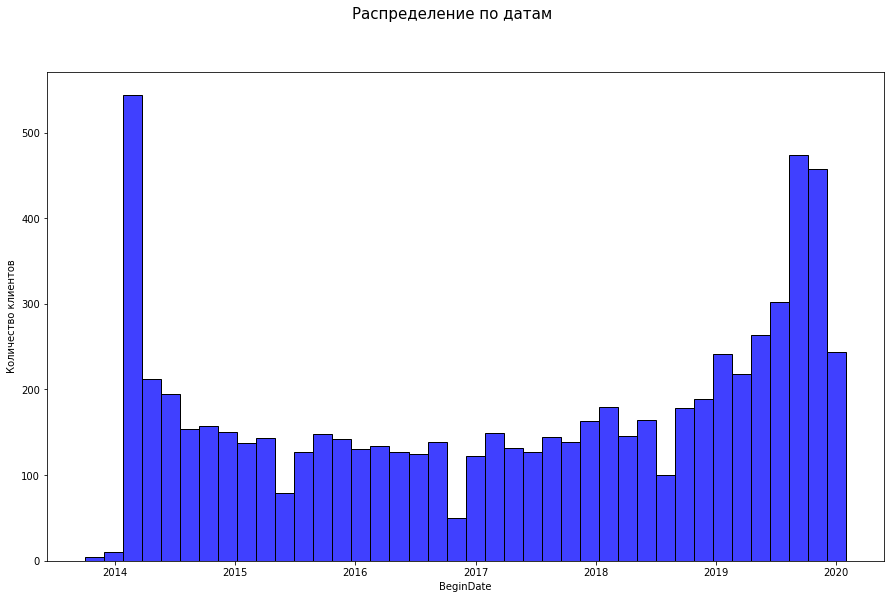

In [121]:
plt.figure(figsize=[15, 9])
plt.suptitle('Распределение по датам', fontsize=15)
sns.histplot(contract, x=contract['BeginDate'], color='b', bins=40)
plt.xlabel('BeginDate')
plt.ylabel('Количество клиентов')
plt.show();

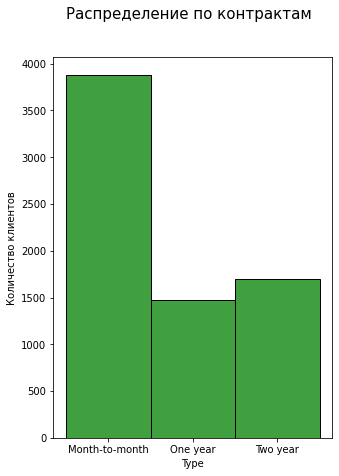

In [17]:
plt.figure(figsize=[5, 7])
plt.suptitle('Распределение по контрактам', fontsize=15)
sns.histplot(contract['Type'], color='g', kde=False)
plt.xlabel('Type')
plt.ylabel('Количество клиентов')
plt.show();

Изучение значений в столбце EndDate:

In [18]:
contract['EndDate'].value_counts()['No']

5942

In [19]:
np.unique(contract['EndDate'])

array(['2014-06-01', '2014-09-01', '2014-10-01', '2014-11-01',
       '2014-12-01', '2015-01-01', '2015-02-01', '2015-03-01',
       '2015-04-01', '2015-05-01', '2015-06-01', '2015-07-01',
       '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01',
       '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
       '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01',
       '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01',
       '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
       '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
       '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01',
       '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01',
       '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01',
       '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01',
       '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01',
       '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01',
       '2019-08-01', '2019-09-01', '2019-10-01', '2019-

Создаем признак действующий/завершенный контракт = 1/0:

In [20]:
contract['status'] = contract['EndDate']
contract.loc[(contract.status != 'No'), 'status'] = 0
contract.loc[(contract.status == 'No'), 'status'] = 1

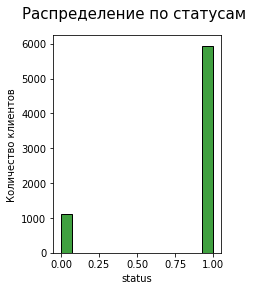

In [21]:
plt.figure(figsize=[3, 4])
plt.suptitle('Распределение по статусам', fontsize=15)
sns.histplot(contract['status'], color='g', kde=False)
plt.xlabel('status')
plt.ylabel('Количество клиентов')
plt.show();

Создаём новый столбец кол-во дней действия контракта:

In [22]:
contract['BeginDate'] = contract['BeginDate'].apply(pd.to_datetime)
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   status            7043 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 495.3+ KB


In [23]:
contract['active_days'] = contract['EndDate']
contract.loc[(contract.active_days == 'No'), 'active_days'] = max(contract['BeginDate'])
contract['active_days'] = contract['active_days'].apply(pd.to_datetime)
contract['active_days'] = contract['active_days']-contract['BeginDate']

In [24]:
contract['active_days'] = contract['active_days'].dt.days

In [25]:
contract

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,status,active_days
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,1,31
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,1,1036
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,1,123
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,1,1371
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,1,153
...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.20,1,730
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.40,1,2191
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.60,1,337
7041,8361-LTMKD,2019-07-01,No,Month-to-month,Yes,Mailed check,74.40,520.80,1,215


In [26]:
contract['active_days'].describe()

count    7043.000000
mean      898.555729
std       683.130510
min         0.000000
25%       276.000000
50%       761.000000
75%      1461.000000
max      2314.000000
Name: active_days, dtype: float64

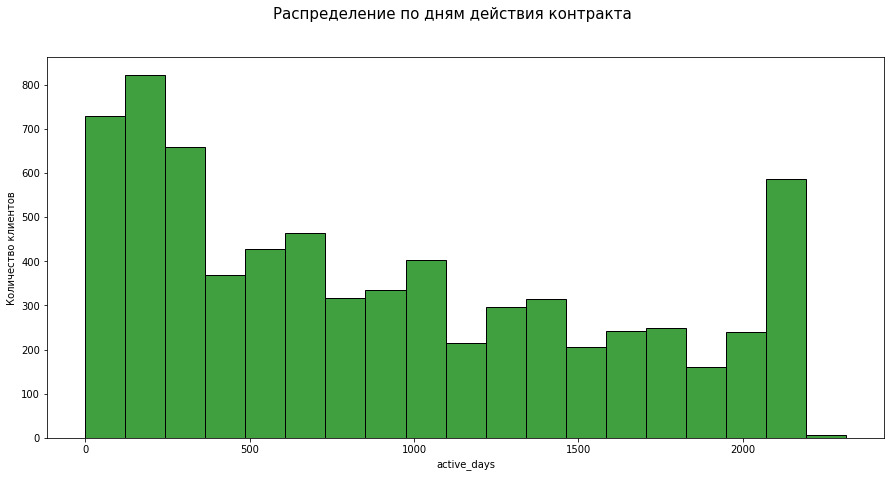

In [27]:
plt.figure(figsize=[15, 7])
plt.suptitle('Распределение по дням действия контракта', fontsize=15)
sns.histplot(contract['active_days'], color='g', kde=False)
plt.xlabel('active_days')
plt.ylabel('Количество клиентов')
plt.show();

Распределние по дням выглядит логично, помимо пика свыше 2000 дней. Рассмотрим какие типы контрактов туда попали и с какой даты начали действовать. Возможно есть закономернности. 

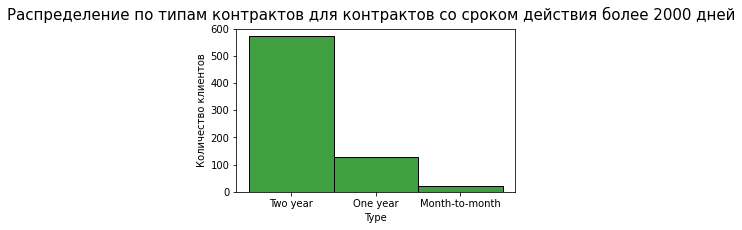

In [28]:
contract_2000 = contract.query('active_days > 2000')
plt.figure(figsize=[5, 3])
plt.suptitle('Распределение по типам контрактов для контрактов со сроком действия более 2000 дней', fontsize=15)
sns.histplot(contract_2000['Type'], color='g', kde=False)
plt.xlabel('Type')
plt.ylabel('Количество клиентов')
plt.show();

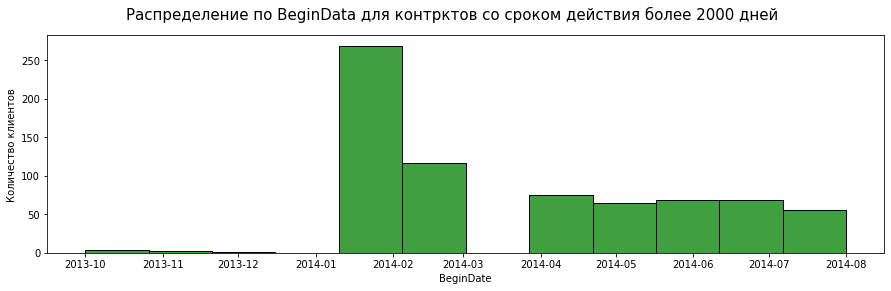

In [29]:
plt.figure(figsize=[15, 4])
plt.suptitle('Распределение по BeginData для контрктов со сроком действия более 2000 дней', fontsize=15)
sns.histplot(contract_2000['BeginDate'], color='g', kde=False)
plt.xlabel('BeginDate')
plt.ylabel('Количество клиентов')
plt.show();

Скорее всего пик был связан с промоакцией на заклюючение 2-ух годичных контрактов в 2014 году.

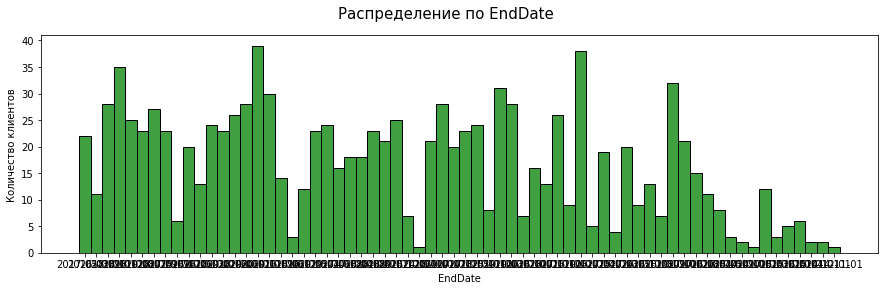

In [123]:
contract_end = contract.query('status == 0')
plt.figure(figsize=[15, 4])
plt.suptitle('Распределение по EndDate', fontsize=15)
sns.histplot(contract_end['EndDate'], color='g', bins=40)
plt.xlabel('EndDate')
plt.ylabel('Количество клиентов')
plt.show();

Явных закономерностей в датах звершения контрактов не наблюдается. 

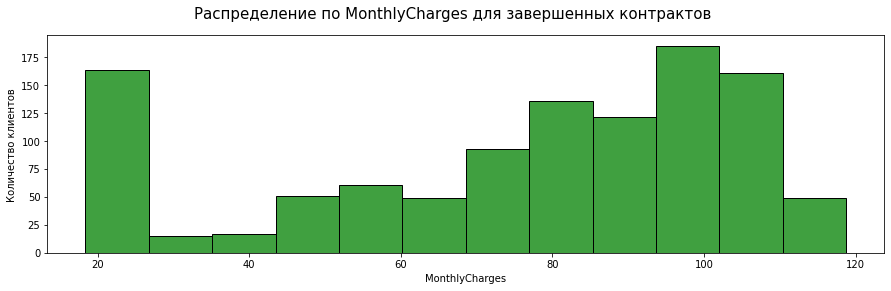

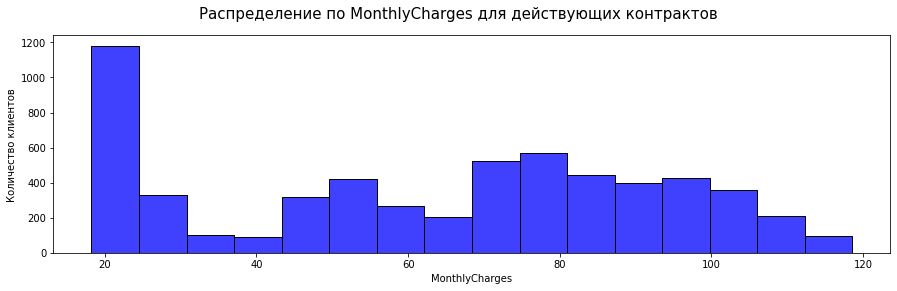

In [31]:
contract_end = contract.query('status == 0')
plt.figure(figsize=[15, 4])
plt.suptitle('Распределение по MonthlyCharges для завершенных контрактов', fontsize=15)
sns.histplot(contract_end['MonthlyCharges'], color='g', kde=False)
plt.xlabel('MonthlyCharges')
plt.ylabel('Количество клиентов')
plt.show();

contract_active = contract.query('status == 1')
plt.figure(figsize=[15, 4])
plt.suptitle('Распределение по MonthlyCharges для действующих контрактов', fontsize=15)
sns.histplot(contract_active['MonthlyCharges'], color='b', kde=False)
plt.xlabel('MonthlyCharges')
plt.ylabel('Количество клиентов')
plt.show();

Месячные платежи по завершенным контракта выше действущмх контрактов, если это не связано с доп. опциями - могло повлиять на решения клиентов прекратить сотрудничество.

Таблица Personal:

In [32]:
personal

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


In [33]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [34]:
personal.duplicated().sum()

0

Таблица internet:

In [35]:
internet

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


In [36]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [37]:
internet.duplicated().sum()

0

Таблица phone:

In [38]:
phone

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


In [39]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [40]:
phone.duplicated().sum()

0

## Объединение таблиц

In [41]:
data = pd.merge(contract, personal, on='customerID', how='left')
data = pd.merge(data, internet, on='customerID', how='left')
data = pd.merge(data, phone, on='customerID', how='left')
data.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,status,active_days,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,1,31,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,1,1036,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,1,123,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60,1,1371,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50,1,153,...,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,1,337,...,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,1,671,...,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,1,306,...,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,1,945,...,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,0,882,...,No,Yes,DSL,Yes,Yes,No,No,No,No,No


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   status            7043 non-null   object        
 9   active_days       7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   5517 n

Исследование коллинеарности:

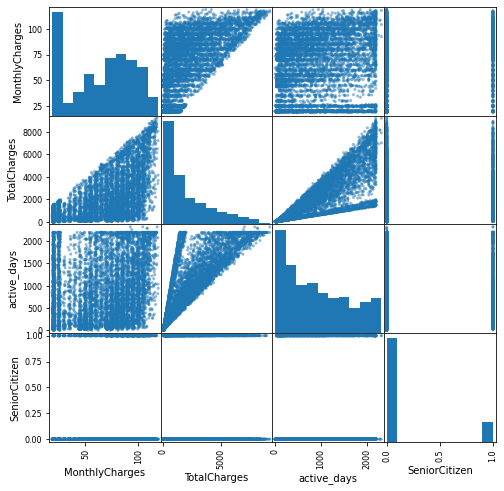

In [43]:
pd.plotting.scatter_matrix(data, figsize=(8,8));

In [44]:
data.corr()

,MonthlyCharges,TotalCharges,active_days,SeniorCitizen
MonthlyCharges,1.000000,0.630448,0.220054,0.220173
TotalCharges,0.630448,1.000000,0.821731,0.093974
active_days,0.220054,0.821731,1.000000,0.005283
SeniorCitizen,0.220173,0.093974,0.005283,1.000000


In [45]:
data.phik_matrix();

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'active_days', 'SeniorCitizen']


Высокие коэффициенты наблюдаются между:
- BeginDate и Type
- BeginDate и TotalCharges
- BeginDate и active_days
- MonthlyCharges и TotalCharges
- active_days и TotalCharges
- active_days и BeginDate
- partner и dependents
- active_days и Type

Мультиколлинеарность может негативно сказаться на линейных моделях, в тоже время удаление мультиколлиенарных признаков понизят точность предсказания. В приоритете использование других моделей.

In [48]:
cols = ['BeginDate','Type']
data[cols].hist2d()

Type,Month-to-month,One year,Two year
BeginDate,,,
2013-10-01,0.0,1.0,2.0
2013-11-01,0.0,0.0,2.0
2013-12-01,0.0,0.0,3.0
2014-01-01,0.0,4.0,3.0
2014-02-01,3.0,19.0,344.0
...,...,...,...
2019-10-01,227.0,6.0,4.0
2019-11-01,227.0,7.0,3.0
2019-12-01,214.0,5.0,1.0


In [49]:
data[cols].outlier_significance_matrix()

Type,Month-to-month,One year,Two year
BeginDate,,,
2013-10-01,-2.044898,0.384697,1.306443
2013-11-01,-1.690626,-0.683331,1.306972
2013-12-01,-2.044898,-0.858019,1.888212
2014-01-01,-3.143829,1.948614,0.983059
2014-02-01,-8.209536,-8.209536,30.519192
...,...,...,...
2019-10-01,14.560390,-8.209536,-8.209536
2019-11-01,14.560390,-8.125891,-8.209536
2019-12-01,14.727974,-8.209536,-8.209536


#### Заполняем отсутвующие значения в столбцах

Отсутвие некоторых клиентов в подтаблице Internet скорее всего связано с отсутвием данных услуг в их договоре - логично заполнить пропуски значением 'No'. 

In [50]:
data[['InternetService', 'OnlineSecurity', 
          'OnlineBackup', 'DeviceProtection', 
          'TechSupport', 'StreamingTV', 
          'StreamingMovies']] = data[['InternetService', 'OnlineSecurity', 
                                                           'OnlineBackup', 'DeviceProtection',
                                                           'TechSupport', 'StreamingTV', 
                                                           'StreamingMovies']].fillna('No')

data['InternetService'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

Пропуски в столбце Multiplelines заполним значением 'unknown', т.к. логика пропуска неочевидная.

In [51]:
data['MultipleLines'] = data['MultipleLines'].fillna('unknown')
data['MultipleLines'].unique()

array(['unknown', 'No', 'Yes'], dtype=object)

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   status            7043 non-null   object        
 9   active_days       7043 non-null   int64         
 10  gender            7043 non-null   object        
 11  SeniorCitizen     7043 non-null   int64         
 12  Partner           7043 non-null   object        
 13  Dependents        7043 non-null   object        
 14  InternetService   7043 n

Пропусков нет.

## Машинное обучение

#### Определяем target и features, разбиваем на train и test выборки 

In [53]:
target = data['status']

features = data.drop(['status', 'customerID', 'BeginDate', 'EndDate'], axis=1)

features.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,active_days,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,Month-to-month,Yes,Electronic check,29.85,31.04,31,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,unknown
1,One year,No,Mailed check,56.95,2071.84,1036,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,Month-to-month,Yes,Mailed check,53.85,226.17,123,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,One year,No,Bank transfer (automatic),42.30,1960.60,1371,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,unknown
4,Month-to-month,Yes,Electronic check,70.70,353.50,153,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Убираем признаки BeginDate и EndDate для предотвращения утечки. Убираем признак customerID, нужен был для объединения таблиц - для моделирования не нужен.

In [54]:
print('Размер целевого признаков:', target.shape)
print('Размер features:', features.shape)

Размер целевого признаков: (7043,)
Размер features: (7043, 18)


In [55]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   active_days       7043 non-null   int64  
 6   gender            7043 non-null   object 
 7   SeniorCitizen     7043 non-null   int64  
 8   Partner           7043 non-null   object 
 9   Dependents        7043 non-null   object 
 10  InternetService   7043 non-null   object 
 11  OnlineSecurity    7043 non-null   object 
 12  OnlineBackup      7043 non-null   object 
 13  DeviceProtection  7043 non-null   object 
 14  TechSupport       7043 non-null   object 
 15  StreamingTV       7043 non-null   object 
 16  StreamingMovies   7043 non-null   object 


Делим на выборки в соотношении 75:25:

In [56]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=.25, random_state=RANDOM_STATE)

In [75]:
#КОД ТИМЛИДА

X_train = features_train.copy()
X_test = features_test.copy()

In [76]:
features_train.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,active_days,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
3760,Month-to-month,Yes,Credit card (automatic),73.60,220.80,92,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No
3220,Two year,No,Credit card (automatic),77.30,1688.23,640,Male,0,Yes,No,DSL,Yes,No,Yes,Yes,No,Yes,Yes
3648,One year,Yes,Electronic check,90.15,4597.65,1553,Female,0,Yes,Yes,Fiber optic,No,No,Yes,No,No,Yes,Yes
6713,Month-to-month,Yes,Electronic check,95.90,1342.60,426,Male,1,No,No,Fiber optic,No,Yes,Yes,No,No,Yes,Yes
5175,One year,No,Mailed check,20.35,407.00,610,Female,0,Yes,No,No,No,No,No,No,No,No,No


In [77]:
X_train.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,active_days,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
3760,Month-to-month,Yes,Credit card (automatic),73.60,220.80,92,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No
3220,Two year,No,Credit card (automatic),77.30,1688.23,640,Male,0,Yes,No,DSL,Yes,No,Yes,Yes,No,Yes,Yes
3648,One year,Yes,Electronic check,90.15,4597.65,1553,Female,0,Yes,Yes,Fiber optic,No,No,Yes,No,No,Yes,Yes
6713,Month-to-month,Yes,Electronic check,95.90,1342.60,426,Male,1,No,No,Fiber optic,No,Yes,Yes,No,No,Yes,Yes
5175,One year,No,Mailed check,20.35,407.00,610,Female,0,Yes,No,No,No,No,No,No,No,No,No


In [59]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 3760 to 6088
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5282 non-null   object 
 1   PaperlessBilling  5282 non-null   object 
 2   PaymentMethod     5282 non-null   object 
 3   MonthlyCharges    5282 non-null   float64
 4   TotalCharges      5282 non-null   float64
 5   active_days       5282 non-null   int64  
 6   gender            5282 non-null   object 
 7   SeniorCitizen     5282 non-null   int64  
 8   Partner           5282 non-null   object 
 9   Dependents        5282 non-null   object 
 10  InternetService   5282 non-null   object 
 11  OnlineSecurity    5282 non-null   object 
 12  OnlineBackup      5282 non-null   object 
 13  DeviceProtection  5282 non-null   object 
 14  TechSupport       5282 non-null   object 
 15  StreamingTV       5282 non-null   object 
 16  StreamingMovies   5282 non-null   objec

Кодируем категориальные признаки с помощью OrdinalEncoder.

In [80]:
cat_columns = X_train.select_dtypes('object').columns.to_list()

encoder = OrdinalEncoder()

features_train_oe = X_train.copy()
features_test_oe = X_test.copy()

features_train_oe[cat_columns] = encoder.fit_transform(features_train[cat_columns])
features_test_oe[cat_columns] = encoder.transform(features_test[cat_columns])

In [102]:
features_train_oe.isna().sum()

Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
active_days         0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

In [119]:
#изменяем тип данных всех признаков на int:
target_train = target_train.astype('int')
target_test = target_test.astype('int')
features_train_oe[cat_columns + ['SeniorCitizen']] = features_train_oe[cat_columns + ['SeniorCitizen']].astype('int')
features_test_oe[cat_columns + ['SeniorCitizen']] = features_test_oe[cat_columns + ['SeniorCitizen']].astype('int')

In [120]:
features_train_oe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 3760 to 6088
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              5282 non-null   int64  
 1   PaperlessBilling  5282 non-null   int64  
 2   PaymentMethod     5282 non-null   int64  
 3   MonthlyCharges    5282 non-null   float64
 4   TotalCharges      5282 non-null   float64
 5   active_days       5282 non-null   int64  
 6   gender            5282 non-null   int64  
 7   SeniorCitizen     5282 non-null   int64  
 8   Partner           5282 non-null   int64  
 9   Dependents        5282 non-null   int64  
 10  InternetService   5282 non-null   int64  
 11  OnlineSecurity    5282 non-null   int64  
 12  OnlineBackup      5282 non-null   int64  
 13  DeviceProtection  5282 non-null   int64  
 14  TechSupport       5282 non-null   int64  
 15  StreamingTV       5282 non-null   int64  
 16  StreamingMovies   5282 non-null   int64

#### Обучение моделей

##### Cat Boost Classifier

Объявляем функцию обучения модели с помощью GridSearch и TimeSerSpli:
- на вход получает модель и сетку гиперпараметров
- возвращает обученную модель, best_score_ и best_estimator_ для дальнейшего тестирования

In [108]:
def modeling(model_type, param):
    grid = GridSearchCV(model_type, param, scoring='roc_auc', cv=TimeSeriesSplit(n_splits=5))

    model = grid.fit(features_train_oe, target_train)
    best_estimator = grid.best_estimator_
    best_score = grid.best_score_
    
    print('Лучшие параметры:', grid.best_params_)
    print('Лучшее значение:', grid.best_score_)
    
    return model, best_estimator, best_score

Обучение:

In [109]:
%%time
model_cat = CatBoostClassifier()
cat_param = {'random_state': [RANDOM_STATE], 'iterations': [50, 100, 500], 
             'depth': [5, 7, 10], 'learning_rate': [0.5, 0.1, 0.01]
            }

cat_model, cat_best_est, cat_best_sc = modeling(model_cat, cat_param);

0:	learn: 0.5438242	total: 944us	remaining: 46.3ms
1:	learn: 0.4667416	total: 2.23ms	remaining: 53.6ms
2:	learn: 0.4173812	total: 3.16ms	remaining: 49.6ms
3:	learn: 0.3931177	total: 3.9ms	remaining: 44.8ms
4:	learn: 0.3802944	total: 4.67ms	remaining: 42ms
5:	learn: 0.3637184	total: 5.63ms	remaining: 41.3ms
6:	learn: 0.3534155	total: 6.43ms	remaining: 39.5ms
7:	learn: 0.3436547	total: 7.22ms	remaining: 37.9ms
8:	learn: 0.3360868	total: 8.02ms	remaining: 36.5ms
9:	learn: 0.3287339	total: 8.89ms	remaining: 35.6ms
10:	learn: 0.3237675	total: 9.64ms	remaining: 34.2ms
11:	learn: 0.3195823	total: 10.4ms	remaining: 33ms
12:	learn: 0.3120347	total: 11.2ms	remaining: 31.9ms
13:	learn: 0.3067562	total: 11.9ms	remaining: 30.6ms
14:	learn: 0.3022686	total: 12.8ms	remaining: 29.8ms
15:	learn: 0.2973153	total: 13.6ms	remaining: 28.9ms
16:	learn: 0.2888226	total: 14.4ms	remaining: 28ms
17:	learn: 0.2863116	total: 15.3ms	remaining: 27.1ms
18:	learn: 0.2807480	total: 16ms	remaining: 26.2ms
19:	learn: 0.

Краткий итог.

В рузьтате обучения модели CatBoost Classifier на тренировочной выборки было достигнуто значение целевой метрики ROC-AUC = 0,857.

Лучшие параметры из сетки: 'depth' - 5, 'iterations' - 500, 'learning_rate' - 0.1,

Время обучения: 5min 7s

Объявляем функцию построения гистограммы значимости признаков:
- на вход получает обученную модель и признаки из тренировочной выбоки
- возвращает визуализацию гистограммы

In [114]:
def importance_hist(model_fitted, features):
    return pd.Series(model_fitted.best_estimator_.feature_importances_, index=features.columns).sort_values(ascending=True).plot.barh(figsize=(15, 10), grid=True)

Объявляем функцию построения матрицы ошибок:
- на вход получает целевой признак и предсказания
- возвращает визуализацию матрицы

In [116]:
def confusion_m(target, predictions):
    cf_matrix = confusion_matrix(target, predictions)

    group_names = ['True Neg','False Pos','False Neg','True Pos']

    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)

    ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])

    ## Display the visualization of the Confusion Matrix.
    return plt.show()


##### LGBM Classifier

In [110]:
%%time
model_LGBM = LGBMClassifier()

LGBM_param = {
    'learning_rate': [0.1, 0.3, 0.01], 
    'n_estimators': [50,100,500],
    'max_depth': [3,5,10],
    'random_state': [RANDOM_STATE]
}

lgb_model, lgb_best_est, lgb_best_sc = modeling(model_LGBM, LGBM_param);

Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'random_state': 310723}
Лучшее значение: 0.8342367659788803
CPU times: user 21min 32s, sys: 6.76 s, total: 21min 39s
Wall time: 21min 48s


В рузьтате обучения модели LGBM Classifier на тренировочной выборки было достигнуто значение целевой метрики ROC-AUC = 0.83.

Лучшие параметры из сетки: 'max_depth' - 3, 'n_estimators' - 500, 'learning_rate' - 0.1

Время обучения: 21min 48s (не типично - особенность работы платформы).

##### Random Forest Classifier

In [111]:
%%time
model_RF= RandomForestClassifier()
RF_param = {
    'max_depth' : range(2,10),
    'min_samples_leaf' : range(1,3),
    'n_estimators': [100, 300, 500],
    'random_state': [RANDOM_STATE]
}
rfc_model, rfc_best_est, rfc_best_sc = modeling(model_RF, RF_param);

Лучшие параметры: {'max_depth': 8, 'min_samples_leaf': 1, 'n_estimators': 300, 'random_state': 310723}
Лучшее значение: 0.8250560274639408
CPU times: user 2min 54s, sys: 1.45 s, total: 2min 56s
Wall time: 2min 56s


В рузьтате обучения модели Random Forest Classifier на тренировочной выборки было достигнуто значение целевой метрики ROC-AUC = 0.825.

Лучшие параметры из сетки: 'max_depth' - 8, 'min_samples_leaf' - 1, 'n_estimators' - 300,

Время обучения: 2min 56s

#### Тестирование лучшей модели CatBoostCalssifier с гиперпараметрам: 'depth'- 5, 'iterations'- 500, 'learning_rate'- 0.1.

In [113]:
pred_test = cat_best_est.predict(features_test_oe)

probabilities_valid = cat_best_est.predict_proba(features_test_oe)
probabilities_one_valid = probabilities_valid[:, 1]

#расчет метрик
auc_roc_test = roc_auc_score(target_test, probabilities_one_valid)    
recall_test = recall_score(target_test, pred_test, zero_division=0)
precision_test = precision_score(target_test, pred_test, zero_division=0)
accuracy_test = cat_best_est.score(features_test_oe, target_test)

#вывод результатов
print('CatBoostClassifier:')
print('ROC-AUC на тренировочной выборке: {:.4f}'.format(cat_best_sc))
    
report_cat = pd.DataFrame({('CatBoost'): [auc_roc_test, 
                                         recall_test,
                                         precision_test,
                                         accuracy_test]}, index=['ROC-AUC', 
                                                                 'Recall',
                                                                 'Precision',
                                                                 'Accuracy'])
report_cat

CatBoostClassifier:
ROC-AUC на тренировочной выборке: 0.8574


,CatBoost
ROC-AUC,0.925460
Recall,0.985859
Precision,0.923659
Accuracy,0.919364


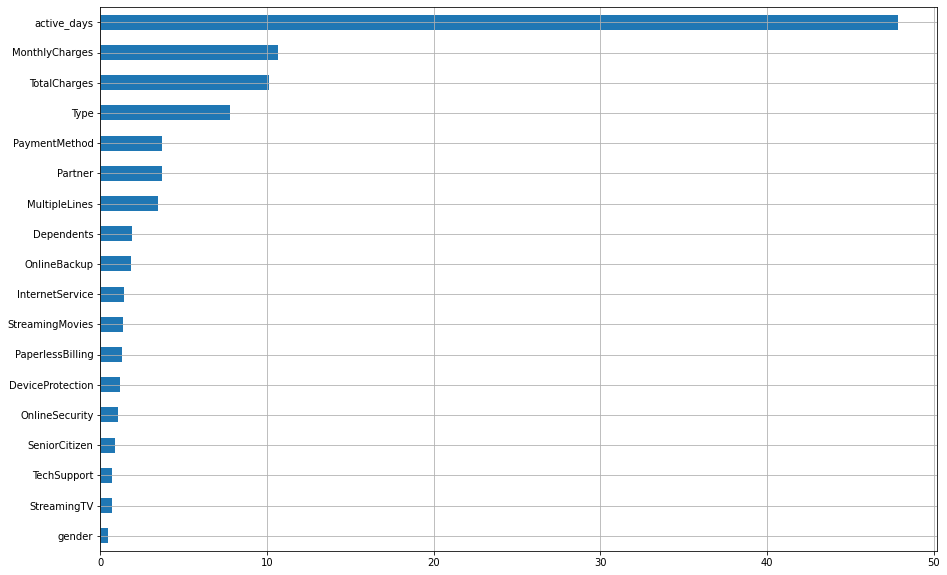

In [115]:
importance_hist (cat_model, features_train_oe);

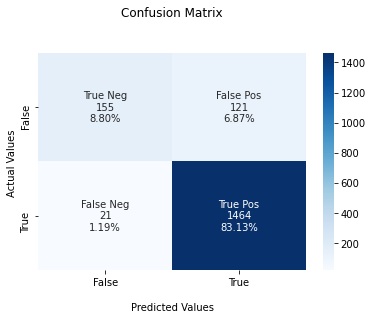

In [117]:
confusion_m(target_test, pred_test)

Выводы:

В рузьтате обучения модели CatBoost Classifier на тренировочной выборки было достигнуто значение целевой метрики ROC-AUC = 0,857. На тестовой - 0.925, целевой уровень (0.85 и выше) достигнут.

Лучшие параметры из сетки: 'depth' - 5, 'iterations' - 500, 'learning_rate' - 0.1,

Время обучения: 5min 7s

Признаки с наибольшим весом: active_days, MonthlyCharges, TotalCharge и Type.

- Истинноположительных предсказаний - 1464 (83.13% от всего кол-ва предсказаний)
- Истинноположительных отрицательных - 155
- Ложноположительных - 121
- Ложноотрицательных - 21

## Итоговый отчет

#### Цель исследования - проверить достижимость метрики, привязанной к прогнозу оттока клиентов, ROC-AUC = 0.85 на предоставленном датасете с помощью алгоритмов машинного обучения. 

#### Исходные данные
- датасет разбит на четыре таблицы с соотв. информацией о контрактах с действующими и ушедшими клиентами, в каждой таблице есть один общий параметр - customerID
- в данных нет пропусков и аномалий, масштабирование признаков не требуется
- целевой признак должен базироваться на признаке EndDate - задача классификации
- каждая таблица была исследована по отдельности, основные результаты наблюдений:
  - в базовой таблице 'contracts' 7043 записи
  - дубликатов не выявлено
  - заполнены технические пробелы в поле TotalCharges значениями из поля MonthlyCharges (пробелы связаны с совпадением даты заключения договора с датой выгрузки датасета - 01.02.2020), изменен тип данных на числовой
  - создан целевой признак 'status': 0 - контракт закончен, 1 - контракт активен.
  - для повышения точности моделирования создан дополнительный признак 'active_days' - продолжительность действия контракта в днях по 01.02.2020

#### Распределения данных:
- пиковые периоды заключения контрактов: начало 2014г и конец 2019г
- динамика заключения контрактов отрицательная с 2014г по 2017, рост с 2017 по 2020
- контрактов с типом месяц к месяцу 3800, годовых - 1500 и двух-годичных 1600 единиц
- активных контрактов на 01.02.2020  - 5942
- кол-во контрактов снижается по окололинейному закону к их продолжительности действия кроме пика в 2100 дней - связано с пиком заключения двух-годичных контрактов в 2014 году
- месячные платежи по завершенным контракта выше платежей по действующим контрактам

#### Объединение таблиц:
- запонены отсутствующие значения по доп. услугам internet в логике их отсутствия в контрактах
- пропуски в поле MultipleLines заполнены третьей категорией 'unknown', т.к. логика пропуска неизвестна
- построена матрица коллинеарности - выявлена мультиколлинеарность между несколькими признакам -> линейные модели не применимы

#### Машинное обучение прогнозынх моделей:
- датасет был разбит на две выборки: train/test в пропорции 75:25, т.к. размер данных не позволяет делить на три выборки
- в признаки вошли все поля таблиц кроме status (целевой), customerID, BeginDate (провоцирует утечку) и EndDate (провоцирует утечку), также добвлен дополнительный - active_days
- признаки закодированы методом Ordinal Encoder
- методом кросс-валидации было обучено 3 модели: CatBoostClassifier, LGBM Classifier и Random Dorest Classifier.
- модель с лучшим показателем ROC-AUC = 0.857 на тренировочной выборке и 0.925 на тестовой оказалась CatBoostClassifier
- лучшие гиперапараметры подбирались оптимизатором GridSearchCV: 'depth' - 5, 'iterations' - 500, 'learning_rate' - 0.1
- список всех используемых для обчучения признаков: 'Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',	'TotalCharges',	'active_days',	'gender',	'SeniorCitizen',	'Partner',	'Dependents',	'InternetService',	'OnlineSecurity',	'OnlineBackup',	'DeviceProtection',	'TechSupport',	'StreamingTV',	'StreamingMovies',	'MultipleLines'
- признаки с наибольшим весом: active_days, MonthlyCharges, TotalCharge и Type.


#### Основные сложности:
- выбор / добавление правильных признаков для обучения с учетом утечек и обеспечения требуемой точности
- кодирования признаков методом OE
- выбор списка ГП для моделей
- почему random_state именно такой??

## Выводы - достигнут целевой уровень по метрике.